In [1]:
from __future__ import print_function, division

import os
import pandas as pd
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [1]:
nclasses = 14951
learning_rate = 0.0002
batch_size = 100
num_epochs = 10

In [3]:
#for test
learning_rate = 0.001
batch_size = 100
num_epochs = 10

In [4]:
class LandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.csv_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 
                                'train', 
                                str(self.csv_data.iloc[idx, 2]), 
                                str(self.csv_data.iloc[idx, 0] + '.jpg'))
        image  = io.imread(img_name)
        label  = torch.from_numpy(self.csv_data.iloc[idx, 2:].as_matrix().astype('long').reshape(-1, 1))
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
}

landmarks_dataset = {
    'train' : LandmarksDataset(csv_file  = 'truncated_preprocessed_train.csv',
                               root_dir  = '/mnt/sw/workspace/Google',
                               transform = data_transforms['train']),
    'val'   : LandmarksDataset(csv_file  = 'truncated_preprocessed_test.csv',
                               root_dir  = '/mnt/sw/workspace/Google',
                               transform = data_transforms['val'])
}

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation

dataloaders = {
    x: torch.utils.data.DataLoader(landmarks_dataset[x], batch_size = batch_size, shuffle = True, num_workers = 4)
    for x in ['train', 'val']
}

dataset_sizes = { x: len(landmarks_dataset[x]) for x in ['train', 'val'] }

print(dataset_sizes['train'])
print(dataset_sizes['val'])

10000
2602


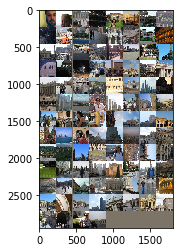

In [7]:
def imshow(inp):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for sampled_batch in dataloaders[phase]:
                inputs = sampled_batch['image']
                labels = sampled_batch['label']
                inputs = Variable(inputs).cuda()
                labels = Variable(labels[:, 0, 0]).cuda()
                optimizer.zero_grad()
            
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds.data == labels.data)
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
        print
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, nclasses)

model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr = learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = num_epochs)

Epoch 1/10
----------
train Loss: 0.0058 Acc: 0.8708
val Loss: 0.0025 Acc: 0.9074
Epoch 2/10
----------
train Loss: 0.0022 Acc: 0.9219
val Loss: 0.0031 Acc: 0.9074
Epoch 3/10
----------
train Loss: 0.0021 Acc: 0.9273
val Loss: 0.0046 Acc: 0.8616
Epoch 4/10
----------
train Loss: 0.0018 Acc: 0.9346
val Loss: 0.0027 Acc: 0.9277
Epoch 5/10
----------
train Loss: 0.0018 Acc: 0.9345
val Loss: 0.0010 Acc: 0.9654
Epoch 6/10
----------
train Loss: 0.0016 Acc: 0.9442
val Loss: 0.0029 Acc: 0.9162
Epoch 7/10
----------
train Loss: 0.0016 Acc: 0.9439
val Loss: 0.0010 Acc: 0.9681
Epoch 8/10
----------
train Loss: 0.0011 Acc: 0.9605
val Loss: 0.0004 Acc: 0.9877
Epoch 9/10
----------
train Loss: 0.0009 Acc: 0.9665
val Loss: 0.0003 Acc: 0.9915
Epoch 10/10
----------
train Loss: 0.0009 Acc: 0.9677
val Loss: 0.0003 Acc: 0.9912
Training complete in 19m 12s
Best val Acc: 0.991545


In [11]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, sampled_batch in enumerate(dataloaders['val']):
        inputs = sampled_batch['image']
        labels = sampled_batch['label']
        inputs = Variable(inputs).cuda()
        labels = Variable(labels[:, 0, 0]).cuda()
    
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

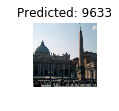

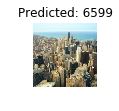

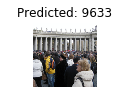

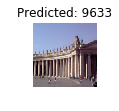

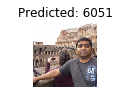

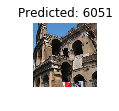

In [12]:
visualize_model(model_ft)